In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import metrics
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Importing all datasets
og_data = pd.read_csv("leads.csv")

In [ ]:
og_data.head()
og_data.shape

In [ ]:
og_data.columns

In [ ]:
og_data.describe()

In [ ]:
og_data.info()

In [ ]:
og_data.isnull().sum()

In [ ]:
round(100*(og_data.isnull().sum()/len(og_data.index)), 2)

In [ ]:
# we can drop Asymmetrique Activity Index , Asymmetrique Profile Index , Asymmetrique Activity Score, Asymmetrique Profile Score 

In [ ]:
og_data.head()

In [3]:
data=og_data.copy()

In [ ]:
Rename_Headers = list(og_data.columns.values)
Corrector = lambda x:x.replace(" ","_")
Rename_Headers = list(map(Corrector,Rename_Headers))
Rename_Headers
data.columns = Rename_Headers

In [ ]:
High_Medium_Low_List =  ["Asymmetrique_Activity_Index","Asymmetrique_Profile_Index"]
def High_Medium_Low_Map(x):
    return x.map({'01.High': "High", "02.Medium": "Medium", "03.Low": "Low"})
data[High_Medium_Low_List] = data[High_Medium_Low_List].apply(High_Medium_Low_Map)

In [ ]:
Binary_Data_Set = data[["Do_Not_Email","Do_Not_Call","Search","Magazine","Newspaper","Newspaper_Article","X_Education_Forums","Digital_Advertisement","Through_Recommendations","Receive_More_Updates_About_Our_Courses","Update_me_on_Supply_Chain_Content","Get_updates_on_DM_Content","I_agree_to_pay_the_amount_through_cheque","A_free_copy_of_Mastering_The_Interview"]]
Categorical_Data_Set = data[['Lead_Origin', 'Lead_Source',"Last_Activity",'Country',"Specialization","How_did_you_hear_about_X_Education","What_is_your_current_occupation","What_matters_most_to_you_in_choosing_a_course","Tags","Lead_Quality",'Lead_Profile','City', "Asymmetrique_Activity_Index","Asymmetrique_Profile_Index", "Last_Notable_Activity"]]

In [ ]:
def Binary_Map(x):
    return x.map({'Yes': 1, "No": 0})

Binary_Data_Set = Binary_Data_Set.apply(Binary_Map)

In [ ]:
Binary_Data_Set = Binary_Data_Set.fillna(0)
Categorical_Data_Set = Categorical_Data_Set.fillna(0)
data= data.fillna(0)

In [ ]:
data.drop(list(Binary_Data_Set.columns),1,inplace=True)
data.drop(list(Categorical_Data_Set.columns),1,inplace=True)
data.drop(["Prospect_ID","Lead_Number"],1,inplace=True)

In [ ]:
Categorical_Data_Dummies = pd.get_dummies(Categorical_Data_Set, drop_first=True)

In [ ]:
data.describe(percentiles=[.25, .5, .75, .90, .95, .99])

In [ ]:
data = pd.concat([data, Binary_Data_Set], axis=1)
data = pd.concat([data, Categorical_Data_Dummies], axis=1)

In [ ]:
reg_data =data.copy()

In [ ]:
X = reg_data.drop(['Converted'], axis=1)
y = reg_data['Converted']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [ ]:
scaler = StandardScaler()
X_train[['TotalVisits','Total_Time_Spent_on_Website','Page_Views_Per_Visit',"Asymmetrique_Activity_Score","Asymmetrique_Profile_Score"]] = scaler.fit_transform(X_train[['TotalVisits','Total_Time_Spent_on_Website','Page_Views_Per_Visit',"Asymmetrique_Activity_Score","Asymmetrique_Profile_Score"]])
X_train.head()

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

In [ ]:
logreg = LogisticRegression()

In [ ]:
rfe = RFE(logreg, 15)
rfe = rfe.fit(X_train, y_train)
rfe.support_

In [ ]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [ ]:
col = X_train.columns[rfe.support_]

In [ ]:
X_train.columns[~rfe.support_]

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

In [ ]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

In [ ]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

In [ ]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

In [ ]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

In [ ]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

In [ ]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

In [ ]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
def VIF_check(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [ ]:
VIF_check(X_train[col])

# EDA

In [ ]:
plt.figure(figsize=[30,4])

plt.subplot(1,3,1)
data["Lead_Origin"].value_counts(normalize=True).plot.pie(autopct='%.0f%%', title="Distribution of Leads by Lead Origin")
plt.xlabel("%Lead Breakup")
plt.ylabel("% Count")

plt.subplot(1,3,2)
(data[(data.Converted==1) & (data["Lead_Origin"])])["Lead_Origin"].value_counts(normalize=True).plot.pie(autopct='%.0f%%', title="Distribution of Converted Leads by Lead Origin")
plt.xlabel("%Lead Breakup")
plt.ylabel("% Count")
plt.show()



plt.figure(figsize=[30,4])
plt.subplot(1,2,1)
data["Lead_Origin"].value_counts().head(5).plot.bar()
plt.title("Top 5 Categories - No of Leads Generated (Blue) and Coverted(Red)") 
plt.xlabel("Categories of Leads by Origin")
plt.ylabel("No of Leads")

plt.subplot(1,2,1)
(data[(data.Converted==1) & (data["Lead_Origin"])])["Lead_Origin"].value_counts().head().plot.bar(color="maroon")
plt.show()

In [ ]:
plt.figure(figsize=[30,4])
plt.subplot(1,3,1)
data["Lead_Source"].value_counts(normalize=True).plot.pie(autopct='%.0f%%', title="Distribution of Leads by Lead Source")
plt.xlabel("%Lead Breakup")
plt.ylabel("% Count")

plt.subplot(1,3,2)
(data[(data.Converted==1) & (data["Lead_Source"])])["Lead_Source"].value_counts(normalize=True).plot.pie(autopct='%.0f%%', title="Distribution of Converted Leads by Lead Source")
plt.xlabel("%Lead Breakup")
plt.ylabel("% Count")
plt.show()



plt.figure(figsize=[30,4])
plt.subplot(1,2,1)
data["Lead_Source"].value_counts().head().plot.bar()

plt.subplot(1,2,1)
(data[(data.Converted==1) & (data["Lead_Source"])])["Lead_Source"].value_counts().head().plot.bar(color="maroon")

plt.title("Top 5 Categories - No of Leads Generated (Blue) and Coverted(Red)") 
plt.xlabel("Categories of Leads by Source")
plt.ylabel("No of Leads")
plt.show()

In [ ]:
plt.figure(figsize=[30,4])
plt.subplot(1,3,1)
data["Lead_Profile"].value_counts(normalize=True).plot.pie(autopct='%.0f%%', title="Distribution of Leads by Lead Profile")
plt.xlabel("%Lead Breakup")
plt.ylabel("% Count")

plt.subplot(1,3,2)
(data[(data.Converted==1) & (data["Lead_Profile"])])["Lead_Profile"].value_counts(normalize=True).plot.pie(autopct='%.0f%%', title="Distribution of Converted Leads by Lead Profile")
plt.xlabel("%Lead Breakup")
plt.ylabel("% Count")
plt.show()



plt.figure(figsize=[30,4])
plt.subplot(1,2,1)
data["Lead_Source"].value_counts().head().plot.bar()

plt.subplot(1,2,1)
(data[(data.Converted==1) & (data["Lead_Profile"])])["Lead_Profile"].value_counts().head().plot.bar(color="maroon")

plt.title("Top 5 Categories - No of Leads Generated (Blue) and Coverted(Red)") 
plt.xlabel("Categories of Leads by Profile")
plt.ylabel("No of Leads")
plt.show()


In [ ]:
plt.figure(figsize = (30,10))
sns.heatmap(data.corr(),annot = True,fmt='0.0%')
plt.show()

In [4]:
data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


# Univariate Analysis

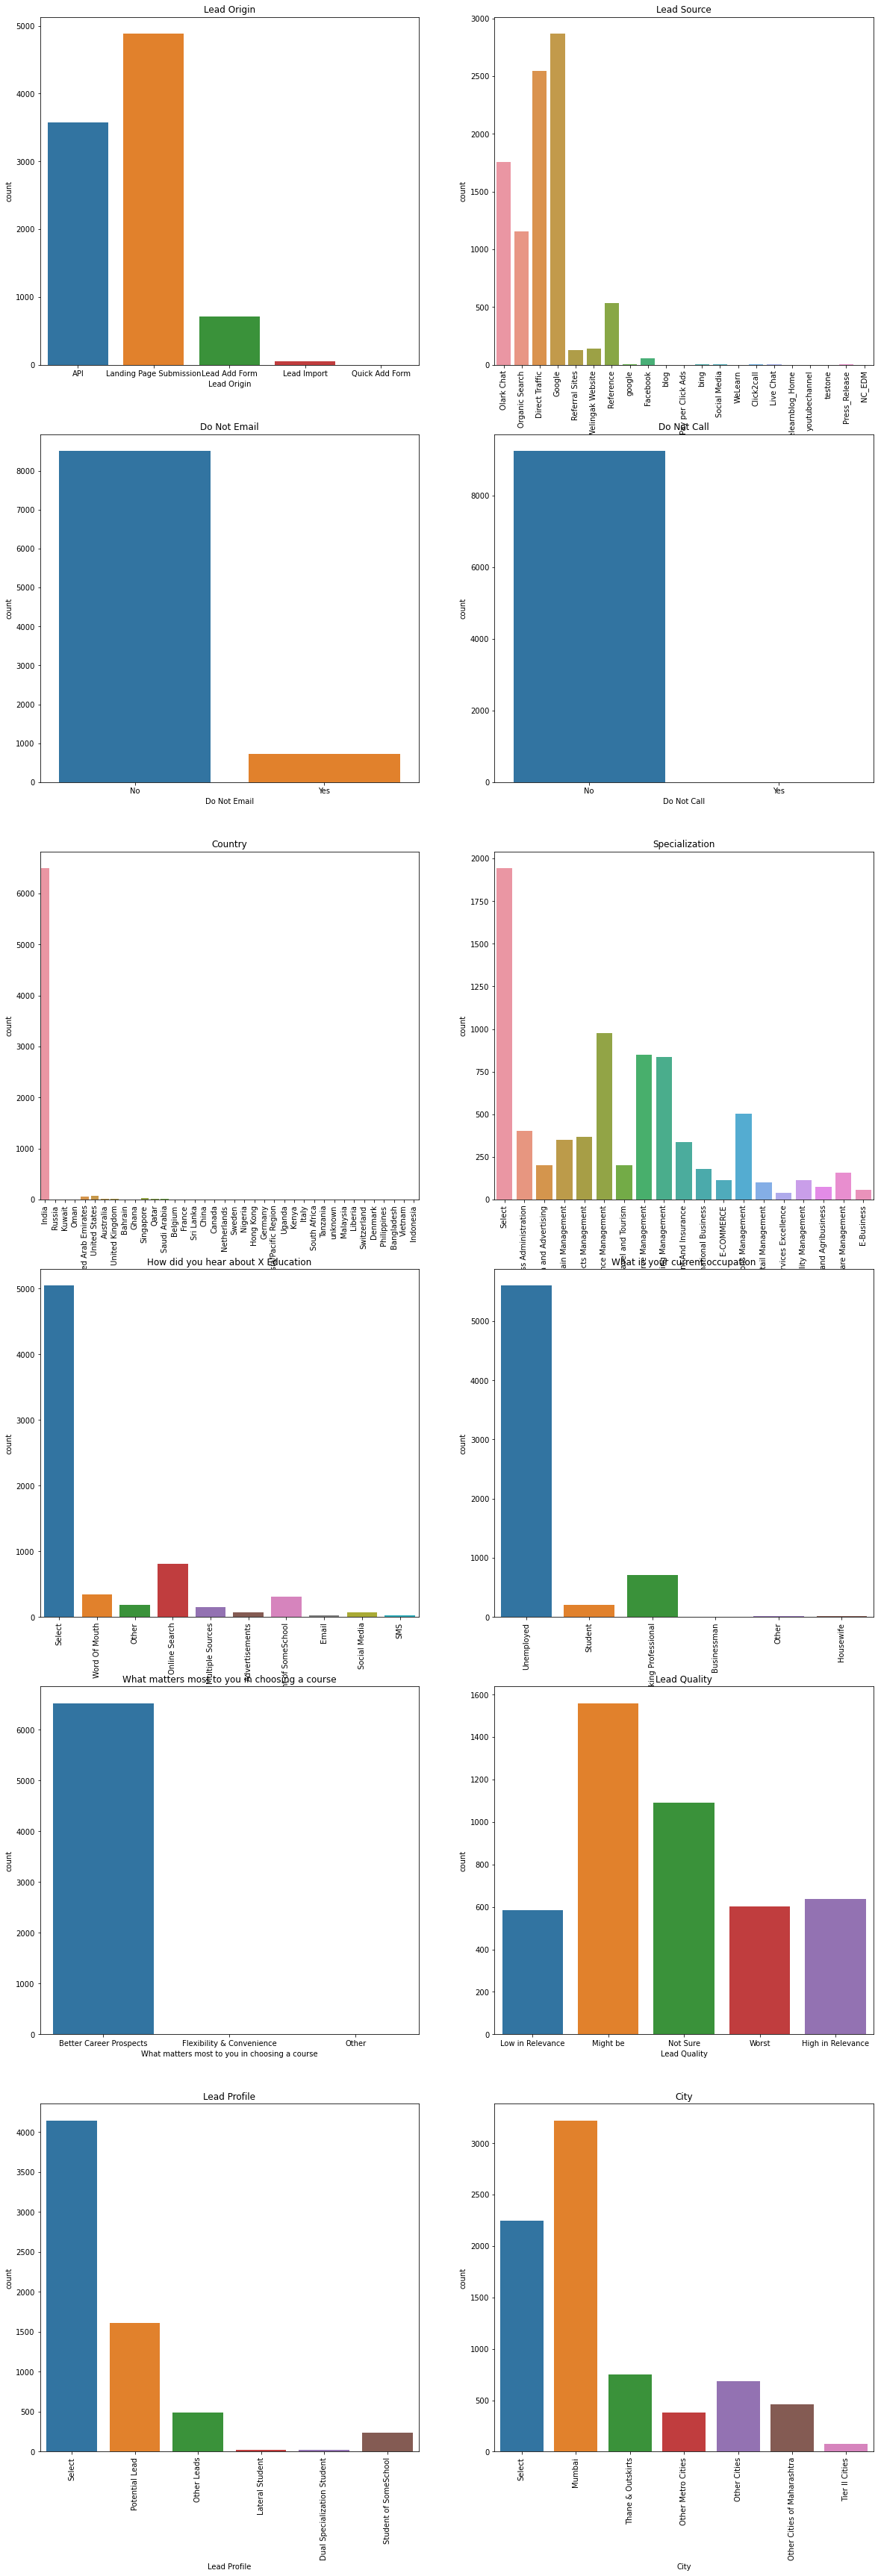

In [13]:
plt.figure(figsize = (20,60))

plt.subplot(6,2,1)
sns.countplot(data['Lead Origin'])
plt.title('Lead Origin')

plt.subplot(6,2,2)
sns.countplot(data['Lead Source'])
plt.xticks(rotation=90)
plt.title('Lead Source')

plt.subplot(6,2,3)
sns.countplot(data['Do Not Email'])
plt.title('Do Not Email')

plt.subplot(6,2,4)
sns.countplot(data['Do Not Call'])
plt.title('Do Not Call')

plt.subplot(6,2,5)
sns.countplot(data['Country'])
plt.xticks(rotation=90)
plt.title('Country')

plt.subplot(6,2,6)
sns.countplot(data['Specialization'])
plt.xticks(rotation=90)
plt.title('Specialization')

plt.subplot(6,2,7)
sns.countplot(data['How did you hear about X Education'])
plt.xticks(rotation=90)
plt.title('How did you hear about X Education')

plt.subplot(6,2,8)
sns.countplot(data['What is your current occupation'])
plt.xticks(rotation=90)
plt.title('What is your current occupation')

plt.subplot(6,2,9)
sns.countplot(data['What matters most to you in choosing a course'])
plt.title('What matters most to you in choosing a course')

plt.subplot(6,2,10)
sns.countplot(data['Lead Quality'])
plt.title('Lead Quality')

plt.subplot(6,2,11)
sns.countplot(data['Lead Profile'])
plt.xticks(rotation=90)
plt.title('Lead Profile')

plt.subplot(6,2,12)
sns.countplot(data['City'])
plt.xticks(rotation=90)
plt.title('City')

plt.show()


## Some observations from the above categorical plots:
    1. The customer who applied through Landing page submission are majorly identified as lead followed by API
    2. The potential buyers are found when Lead source was Google, Direct Traffic, Olak Chat, Organic Search
    3. The buyers are majorly from India and Finance management.
    4. Most of the identified leads and Unemployed followed by Working professional and most of them chose for better career prospects
    5.Majority of the lead buyers are from Mumbai

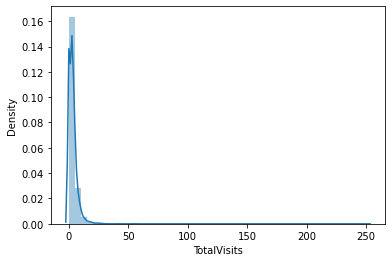

In [14]:
sns.distplot(data['TotalVisits'])
plt.show()

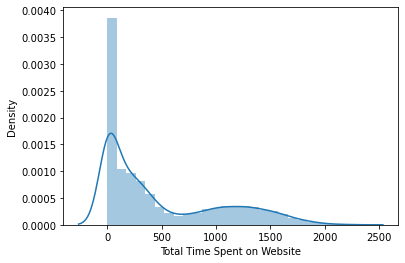

In [15]:
sns.distplot(data['Total Time Spent on Website'])
plt.show()

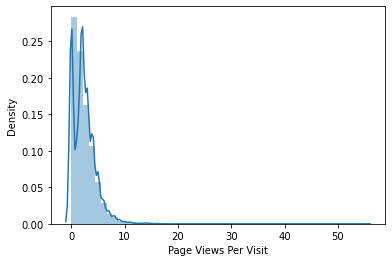

In [16]:
sns.distplot(data['Page Views Per Visit'])
plt.show()

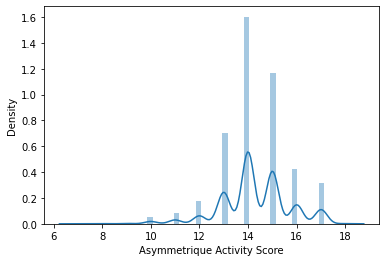

In [17]:
sns.distplot(data['Asymmetrique Activity Score'])
plt.show()

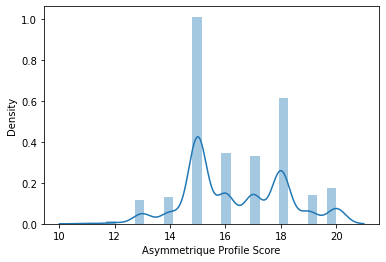

In [18]:
sns.distplot(data['Asymmetrique Profile Score'])
plt.show()

# Bivariate Analysis

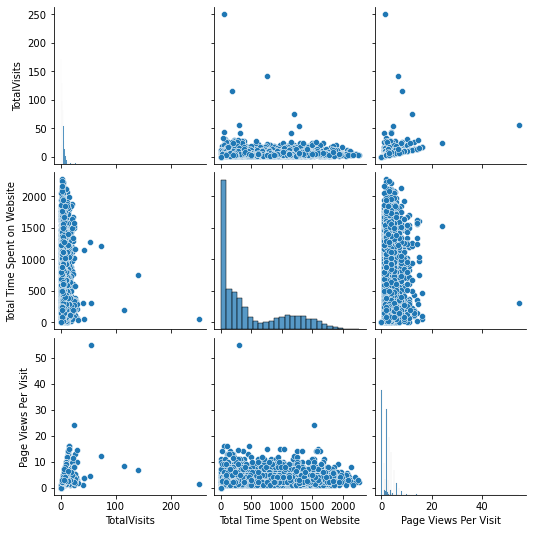

In [19]:
numeric_list = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

sns.pairplot(data, vars=numeric_list)
plt.show()

<AxesSubplot:xlabel='TotalVisits', ylabel='Converted'>

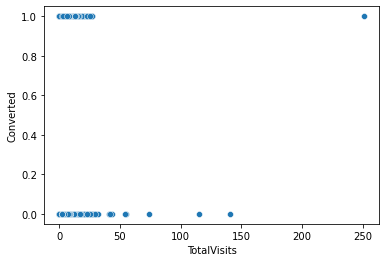

In [24]:
sns.scatterplot(x = 'TotalVisits', y = 'Converted', data = data)

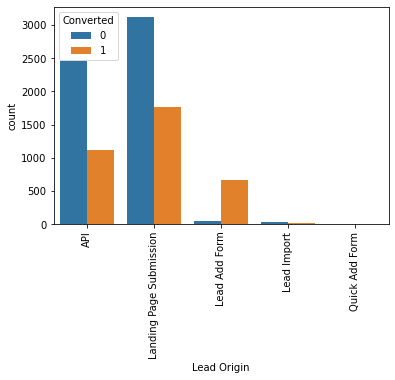

In [26]:
sns.countplot(x = 'Lead Origin', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

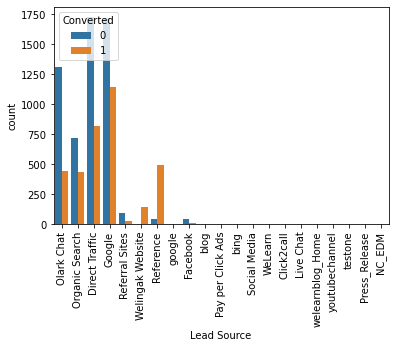

In [27]:
sns.countplot(x = 'Lead Source', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

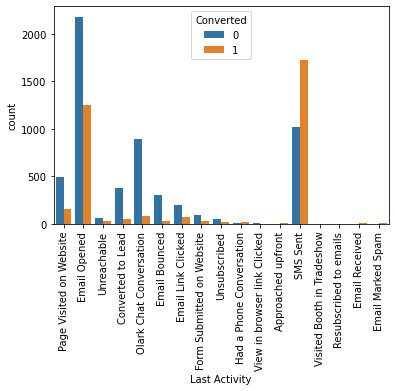

In [28]:
sns.countplot(x = 'Last Activity', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

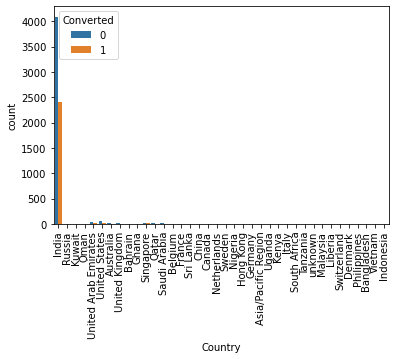

In [29]:
sns.countplot(x = 'Country', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

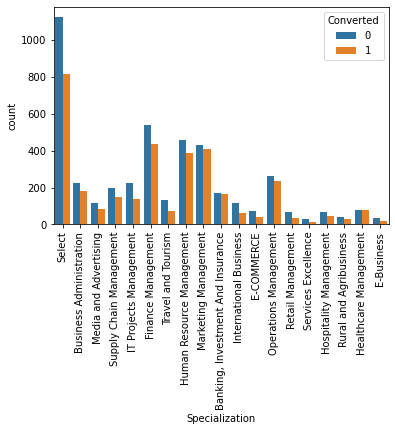

In [30]:
sns.countplot(x = 'Specialization', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

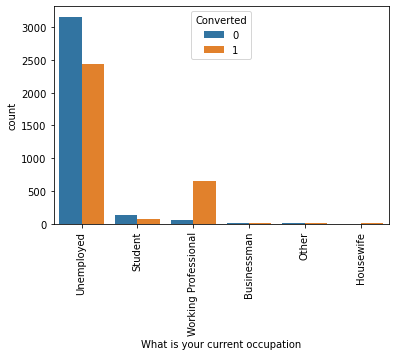

In [31]:
sns.countplot(x = 'What is your current occupation', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

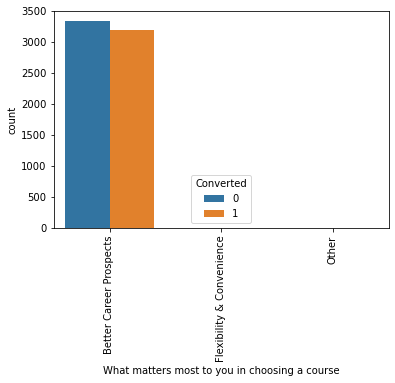

In [34]:
sns.countplot(x = 'What matters most to you in choosing a course', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

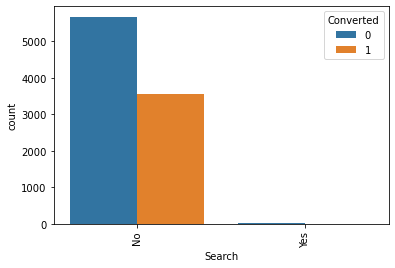

In [35]:
sns.countplot(x = 'Search', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

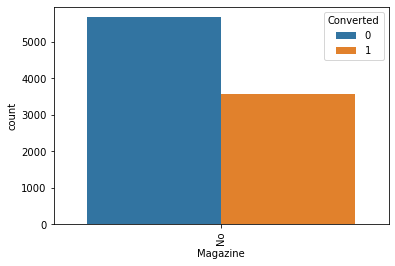

In [36]:
sns.countplot(x = 'Magazine', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

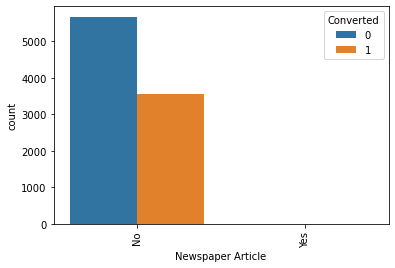

In [37]:
sns.countplot(x = 'Newspaper Article', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

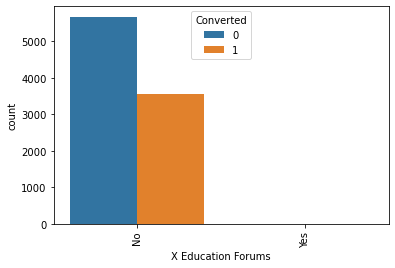

In [38]:
sns.countplot(x = 'X Education Forums', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

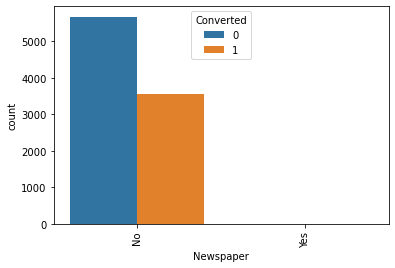

In [39]:
sns.countplot(x = 'Newspaper', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

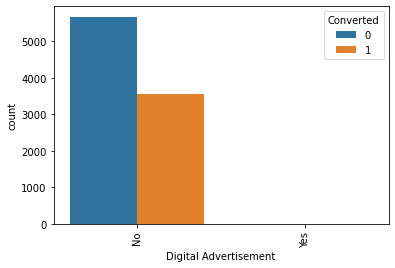

In [40]:
sns.countplot(x = 'Digital Advertisement', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

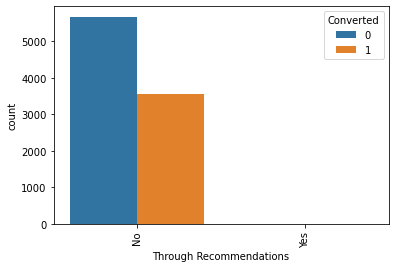

In [42]:
sns.countplot(x = 'Through Recommendations', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

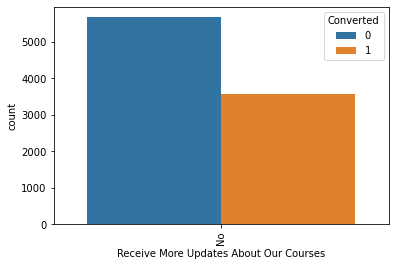

In [43]:
sns.countplot(x = 'Receive More Updates About Our Courses', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

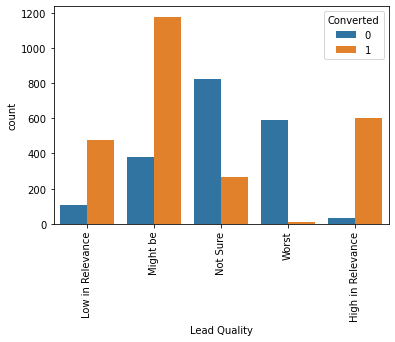

In [49]:
sns.countplot(x = 'Lead Quality', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

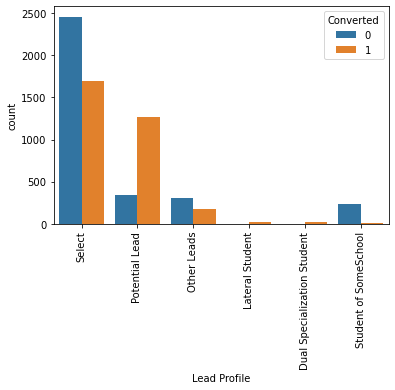

In [50]:
sns.countplot(x = 'Lead Profile', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

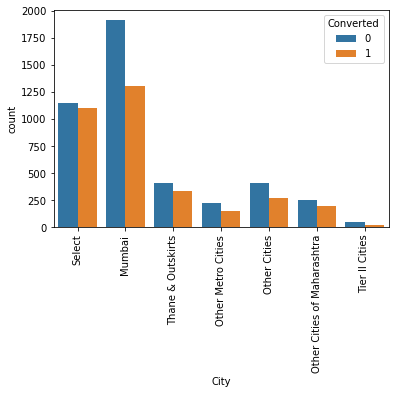

In [51]:
sns.countplot(x = 'City', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

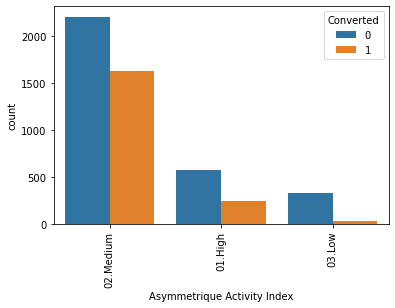

In [52]:
sns.countplot(x = 'Asymmetrique Activity Index', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

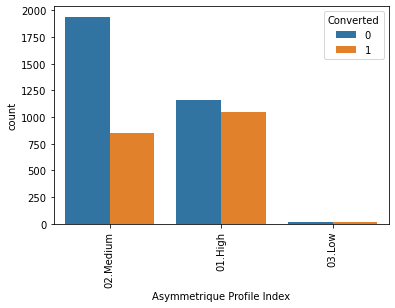

In [53]:
sns.countplot(x = 'Asymmetrique Profile Index', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()

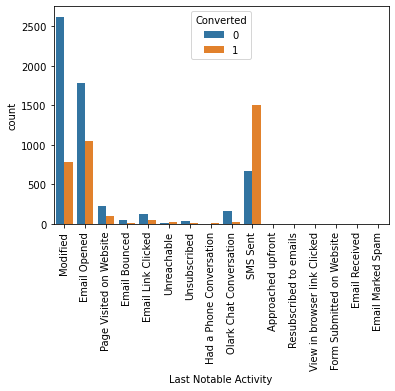

In [54]:
sns.countplot(x = 'Last Notable Activity', hue = 'Converted', data = data)
plt.xticks(rotation = 90)
plt.show()